# IMDB Rating Prediction - Random Forest

In this notebook, we predict the **rating** value using IMDB movie data
with Random Forest. Features:

- Numerical: `votes`, `runtime`
- Categorical: `genre` (multi-hot encoding), `director` (target encoding), `stars` (multi-value target encoding)
- Text: `description` (TF-IDF)

Model:
- `RandomForestRegressor`

Evaluation:
- Primary metric: **RMSE**
- Secondary metrics: **MSE**, **R²**
- Evaluation method:
  - **5-fold cross validation** on the training set (with GridSearchCV)
  - Final performance on a separate **test set** (RMSE, MSE, R²)

## 1. Loading & Cleaning Dataset

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold

In [5]:
#Configuration Constants
MIN_VOTES = 100   #exclude movies with fewer votes
MIN_RUNTIME = 60     #exclude short films (less than 1 hour)
SMOOTH_FACTOR = 10    #smoothing factor for target encoding (prevents overfitting)

In [6]:
data_path = "IMDB_cleaned.csv"   # data_clean.py çıktısı
df = pd.read_csv(data_path)

df = df[df['votes'] > MIN_VOTES]
df = df[df['runtime'] >= MIN_RUNTIME]

print("[INFO] Data size:", df.shape)
df.head()


[INFO] Data size: (39238, 8)


,movie,genre,runtime,rating,stars,description,votes,director
0,Mission: Impossible - Dead Reckoning Part One,"Action, Adventure, Thriller",163,8.0,"Tom Cruise, Hayley Atwell, Ving Rhames, Simon ...",Ethan Hunt and his IMF team must track down a ...,106759,Christopher McQuarrie
1,Sound of Freedom,"Action, Biography, Drama",131,7.9,"Jim Caviezel, Mira Sorvino, Bill Camp, Cristal...",The incredible true story of a former governme...,41808,Alejandro Monteverde
2,They Cloned Tyrone,"Action, Comedy, Mystery",122,6.7,"John Boyega, Jamie Foxx, Teyonah Parris, Kiefe...",A series of eerie events thrusts an unlikely t...,14271,Juel Taylor
3,The Flash,"Action, Adventure, Fantasy",144,6.9,"Ezra Miller, Michael Keaton, Sasha Calle, Mich...",Barry Allen uses his super speed to change the...,126445,Andy Muschietti
4,Transformers: Rise of the Beasts,"Action, Adventure, Sci-Fi",127,6.1,"Anthony Ramos, Dominique Fishback, Luna Lauren...","During the 90s, a new faction of Transformers ...",62180,Steven Caple Jr.


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 39238 entries, 0 to 60914
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movie        39238 non-null  object 
 1   genre        39238 non-null  object 
 2   runtime      39238 non-null  int64  
 3   rating       39238 non-null  float64
 4   stars        39238 non-null  object 
 5   description  39238 non-null  object 
 6   votes        39238 non-null  int64  
 7   director     39238 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.7+ MB


## 4. Feature–Target Separation

- Target (y) = `rating`
- Features (X):
  - Numerical + genre columns: `votes`, `runtime`
  - Categorical columns: `director`, `stars` , `genre` (we will encode them)
  - Text column: `description`


In [8]:
X = df[['votes', 'runtime', 'genre', 'director', 'stars', 'description']]
y = df["rating"]

print("[INFO] X şekli:", X.shape)
print("[INFO] y şekli:", y.shape)

X.head()


[INFO] X şekli: (39238, 6)
[INFO] y şekli: (39238,)


,votes,runtime,genre,director,stars,description
0,106759,163,"Action, Adventure, Thriller",Christopher McQuarrie,"Tom Cruise, Hayley Atwell, Ving Rhames, Simon ...",Ethan Hunt and his IMF team must track down a ...
1,41808,131,"Action, Biography, Drama",Alejandro Monteverde,"Jim Caviezel, Mira Sorvino, Bill Camp, Cristal...",The incredible true story of a former governme...
2,14271,122,"Action, Comedy, Mystery",Juel Taylor,"John Boyega, Jamie Foxx, Teyonah Parris, Kiefe...",A series of eerie events thrusts an unlikely t...
3,126445,144,"Action, Adventure, Fantasy",Andy Muschietti,"Ezra Miller, Michael Keaton, Sasha Calle, Mich...",Barry Allen uses his super speed to change the...
4,62180,127,"Action, Adventure, Sci-Fi",Steven Caple Jr.,"Anthony Ramos, Dominique Fishback, Luna Lauren...","During the 90s, a new faction of Transformers ..."


## 3. Train / Test Split

We will split the data:

- %80 **train**
- %20 **test**



In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("[INFO] Train:", X_train.shape)
print("[INFO] Test :", X_test.shape)


[INFO] Train: (31390, 6)
[INFO] Test : (7848, 6)


## 4. Model Evaluation Function

In [10]:
def evaluate_model(X_train, X_test, y_train, y_test, pipeline=None):
    """
    Model evaluation function with GridSearchCV
    """
    if pipeline is None:
        pipeline = Pipeline(steps=[
            ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
        ])

    # Hiperparametre grid'i - Overfitting'i azaltmak için (optimize edilmiş)
    param_grid = {
        "model__n_estimators": [100, 200],  
        "model__max_depth": [4, 6, 8, 10], 
        "model__min_samples_split": [10, 20],  
        "model__min_samples_leaf": [5, 10], 
        "model__max_features": ["sqrt", 0.7],  
    }

    # 5-Fold CV, primary metric: RMSE
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
    )

    grid_search.fit(X_train, y_train)
    
    # En iyi model
    best_model = grid_search.best_estimator_
    
    # predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Metrics
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_test_pred)

    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse) 
    train_r2 = r2_score(y_train, y_train_pred)
    
    print("========== GRID SEARCH SONUÇLARI ==========")
    print("En iyi hiperparametreler:", grid_search.best_params_)
    print(f"5-Fold CV En İyi Ortalama RMSE: {-grid_search.best_score_:.4f}")
    print("\n========== TEST SET PERFORMANSI ==========")
    print(f"Train RMSE (Primary):   {train_rmse:.4f}    Test RMSE (Primary):   {test_rmse:.4f}")
    print(f"Train MSE  (Secondary): {train_mse:.4f}    Test MSE  (Secondary): {test_mse:.4f}")
    print(f"Train R²   (Secondary): {train_r2:.4f}    Test R²   (Secondary): {test_r2:.4f}")

    #Simple overfitting check
    if train_r2 > test_r2 + 0.10:
        print("\n[WARNING] Risk of overfitting!")
    else:
        print("\n[INFO] Model appears balanced.")
    print("-" * 32 + "\n")
    
    return grid_search, best_model

## 5. Baseline Model
We start with a simple baseline to establish a minimum performance benchmark.

**Strategy:** We drop complex features like **director**, **stars**, **genre**, and **description** because they require advanced preprocessing.

- We use only raw numerical features (**votes, runtime**).

In [11]:
X_train_v1 = X_train.drop(columns=['director', 'stars', 'genre', 'description'])
X_test_v1 = X_test.drop(columns=['director', 'stars', 'genre', 'description'])

y_pred1 = evaluate_model(X_train_v1, X_test_v1, y_train, y_test)

========== GRID SEARCH SONUÇLARI ==========
En iyi hiperparametreler: {'model__max_depth': 8, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 20, 'model__n_estimators': 200}
5-Fold CV En İyi Ortalama RMSE: 1.2196

========== TEST SET PERFORMANSI ==========
Train RMSE (Primary):   1.2028    Test RMSE (Primary):   1.2230
Train MSE  (Secondary): 1.4468    Test MSE  (Secondary): 1.4956
Train R²   (Secondary): 0.1578    Test R²   (Secondary): 0.1412

[INFO] Model appears balanced.
--------------------------------



**Observation:** The baseline model performs very poorly. This confirms that raw numerical features alone (votes and runtime) are not enough to predict movie ratings. We absolutely need to process the categorical and text data to improve the model.

## 6. Basic Feature Engineering

### 6.1 Log Transformation of Votes
The number of votes follows a exponentional distribution (a few movies have millions, most have very few). We applied a log transformation to squash these large values and make the distribution more normal.

In [12]:
# Apply Log transformation (Log(1+x) handles zero values safely)
X_train['log_votes'] = np.log1p(X_train['votes'])
X_test['log_votes'] = np.log1p(X_test['votes'])

# Drop the original 'votes' column to avoid multicollinearity
X_train = X_train.drop(columns=['votes'])
X_test = X_test.drop(columns=['votes'])

### 6.2 Genre Encoding (Multi-hot)

Bu adımda:

- `genre` sütunundaki stringleri sadeleştiriyoruz (boşlukları kaldırıyoruz).
- `str.get_dummies(sep=",")` kullanarak her tür için ayrı bir dummy sütunu (multi-hot encoding) oluşturuyoruz.
- Orijinal `genre` sütununu drop edip yerine bu dummy sütunlarını ekliyoruz.

Bu encoding, hedef değişkeni (**rating**) kullanmadığı için
**train/test split'inden önce** yapmak güvenli (data leakage oluşturmaz).


In [13]:
# 1. Clean spacing
X_train['genre'] = X_train['genre'].str.replace(' ', '')
X_test['genre'] = X_test['genre'].str.replace(' ', '')

# 2. Split genres by comma and get dummy variables
train_genres = X_train['genre'].str.get_dummies(sep=',')
test_genres = X_test['genre'].str.get_dummies(sep=',')

# 3. Join with main dataframe
X_train = pd.concat([X_train, train_genres], axis=1).drop(columns=['genre'])
X_test = pd.concat([X_test, test_genres], axis=1).drop(columns=['genre'])

# 4. ALIGNMENT: Ensure Test columns match Train columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print(f"Training shape after encoding: {X_train.shape}")

X_train.head()

Training shape after encoding: (31390, 31)


,runtime,director,stars,description,log_votes,Action,Adventure,Animation,Biography,Comedy,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
25825,75,Charles Band,"Rhonda Griffin, Justin Lauer, Bill Moynihan, K...","Mad scientist brings Dracula, the Wolfman, the...",6.692084,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
56661,101,Michael Gordon,"Dean Martin, Alain Delon, Rosemary Forsyth, Jo...","In 1845 Texas, a Louisiana belle is courted by...",7.489412,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
27297,118,Pawel Chochlew,"Michal Zebrowski, Robert Zoledziewski, Jan Eng...","September 1st, 1939. German battleship Schlesw...",6.840547,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
41797,91,Edgar Neville,"Roberto Camardiel, Pedro Porcel, George Rigaud...",Life events around a city street and its resid...,4.912655,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24761,105,Jeremy Kagan,"Allan Katz, Corey Parker, Cindy Williams, Melo...",In this version of The Hunchback of Notre Dame...,7.351158,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### 6.3 Model Evaluation (Basic Features)

We now test the model performance using the transformed basic features:

- Log transformed votes **log_votes**
- **runtime**
- One-Hot Encoded **genres**

In [14]:
# We drop the advanced features (Director, Stars, Description) for now
# to see the impact of ONLY Basic Engineering (Log Votes + Genres)
cols_to_drop = ['director', 'stars', 'description']

X_train_v2 = X_train.drop(columns=cols_to_drop)
X_test_v2 = X_test.drop(columns=cols_to_drop)

y_pred2 = evaluate_model(X_train_v2, X_test_v2, y_train, y_test)

========== GRID SEARCH SONUÇLARI ==========
En iyi hiperparametreler: {'model__max_depth': 10, 'model__max_features': 0.7, 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200}
5-Fold CV En İyi Ortalama RMSE: 0.9966

========== TEST SET PERFORMANSI ==========
Train RMSE (Primary):   0.9535    Test RMSE (Primary):   1.0169
Train MSE  (Secondary): 0.9091    Test MSE  (Secondary): 1.0340
Train R²   (Secondary): 0.4708    Test R²   (Secondary): 0.4062

[INFO] Model appears balanced.
--------------------------------



**Observation**: The feature engineering steps (Log-transforming votes and One-Hot Encoding genre) led to a improvement, raising the R^2 score.

This confirms that:

- Correcting the skewness in votes helped the model significantly.
- Genre is a strong predictor of movie ratings.

## 7. Advanced Feature Engineering

### 7.1 Helper Function: Smoothed Encoding Calculation

First, we define a helper function that calculates the weighted average rating for a category (like an Actor or Director).
This function uses **smoothing** to prevent overfitting on rare categories.

$$Score = \frac{count \times mean + m \times global\_mean}{count + m}$$

In [15]:
def calc_smooth_mean(df, by_col, on_col, m=10):
    """
    Calculation Function:
    Groups by a given column (by_col) and calculates the mean of the target column (on_col).
    """
    # Global mean
    global_mean = df[on_col].mean()
    
    # Grouping and Statistics
    agg = df.groupby(by_col)[on_col].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']
    
    # Smoothing Formula
    smooth_score = (counts * means + m * global_mean) / (counts + m)
    
    return smooth_score, global_mean

### 7.2 Applying to Training Set (with K-Fold)

**Critical Step:** To prevent Data Leakage, we cannot simply use the average of the whole training set. If we do, the model sees the movie's own rating inside the actor's score (cheating).

**Solution:** We use **K-Fold Logic**.
1. We split the Training data into 5 parts.
2. For each part, we calculate actor scores using **only the other 4 parts**.
3. This ensures the model predicts a movie's quality using only **other movies'** data.

In [16]:
def get_train_scores(X_train, y_train, col_name, m=10):
    """
    Generates scores for training data using K-Fold method (Prevents leakage).
    """
    # Create a temporary dataframe (X and y together)
    temp_df = X_train.copy()
    temp_df['rating'] = y_train
    
    # Empty series to store results
    oof_scores = pd.Series(index=X_train.index, dtype=float)
    
    # Split data into 5 parts
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(temp_df):
        # Split: 80% Training (train_fold), 20% Validation (val_fold)
        train_fold = temp_df.iloc[train_idx]
        val_fold = temp_df.iloc[val_idx]
        
        if col_name == 'stars':
            # For actors (Multi-value: "Brad Pitt, Tom Cruise")
            # 1. Calculate scores on Train Fold
            exploded_train = train_fold.assign(actor=train_fold['stars'].str.split(',')).explode('actor')
            exploded_train['actor'] = exploded_train['actor'].str.strip()
            actor_map, global_mean = calc_smooth_mean(exploded_train, 'actor', 'rating', m=m)
            
            # 2. Apply these scores to Val Fold
            exploded_val = val_fold.assign(actor=val_fold['stars'].str.split(',')).explode('actor')
            exploded_val['actor'] = exploded_val['actor'].str.strip()
            exploded_val['score'] = exploded_val['actor'].map(actor_map).fillna(global_mean)
            
            # 3. Take average per movie and save
            fold_result = exploded_val.groupby(level=0)['score'].mean()
            oof_scores.iloc[val_idx] = fold_result
            
        else:
            # For director (Single value: "Christopher Nolan")
            target_map, global_mean = calc_smooth_mean(train_fold, col_name, 'rating', m=m)
            oof_scores.iloc[val_idx] = val_fold[col_name].map(target_map).fillna(global_mean)
            
    return oof_scores

# --- APPLICATION ---
X_train['cast_score'] = get_train_scores(X_train, y_train, 'stars', m=10)
X_train['director_score'] = get_train_scores(X_train, y_train, 'director', m=10)
X_train.head()

,runtime,director,stars,description,log_votes,Action,Adventure,Animation,Biography,Comedy,...,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western,cast_score,director_score
25825,75,Charles Band,"Rhonda Griffin, Justin Lauer, Bill Moynihan, K...","Mad scientist brings Dracula, the Wolfman, the...",6.692084,0,0,0,0,1,...,0,0,0,0,0,0,0,0,5.980555,4.910667
56661,101,Michael Gordon,"Dean Martin, Alain Delon, Rosemary Forsyth, Jo...","In 1845 Texas, a Louisiana belle is courted by...",7.489412,0,0,0,0,1,...,0,0,0,0,0,0,0,1,5.851923,6.204902
27297,118,Pawel Chochlew,"Michal Zebrowski, Robert Zoledziewski, Jan Eng...","September 1st, 1939. German battleship Schlesw...",6.840547,0,0,0,0,0,...,0,0,0,0,0,0,1,0,6.066149,5.918824
41797,91,Edgar Neville,"Roberto Camardiel, Pedro Porcel, George Rigaud...",Life events around a city street and its resid...,4.912655,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6.040366,5.988872
24761,105,Jeremy Kagan,"Allan Katz, Corey Parker, Cindy Williams, Melo...",In this version of The Hunchback of Notre Dame...,7.351158,0,0,0,0,1,...,0,0,0,0,0,0,0,0,6.087361,6.119200


### 7.3 Applying to Test Set

For the **Test Set**, we don't need K-Fold. We want our model to use **all available knowledge**.
So, we calculate actor/director scores using the **entire Training Set** and map them to the Test Set.

In [17]:
def get_test_scores(X_train, y_train, X_test, col_name, m=10):
    """
    Scores the Test set using the entire training set.
    """
    # Combine all Training data
    full_train = X_train.copy()
    full_train['rating'] = y_train
    
    if col_name == 'stars':
        # Calculate for actors
        exploded = full_train.assign(actor=full_train['stars'].str.split(',')).explode('actor')
        exploded['actor'] = exploded['actor'].str.strip()
        actor_map, global_mean = calc_smooth_mean(exploded, 'actor', 'rating', m=m)
        
        # Apply to Test set
        exploded_test = X_test.assign(actor=X_test['stars'].str.split(',')).explode('actor')
        exploded_test['actor'] = exploded_test['actor'].str.strip()
        exploded_test['score'] = exploded_test['actor'].map(actor_map).fillna(global_mean)
        
        return exploded_test.groupby(level=0)['score'].mean()
        
    else:
        # Calculate for director
        target_map, global_mean = calc_smooth_mean(full_train, col_name, 'rating', m=m)
        return X_test[col_name].map(target_map).fillna(global_mean)

# --- APPLICATION ---
X_test['cast_score'] = get_test_scores(X_train, y_train, X_test, 'stars', m=10)
X_test['director_score'] = get_test_scores(X_train, y_train, X_test, 'director', m=10)

# Drop unnecessary columns
cols_to_drop = ['stars', 'director']
X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop, errors='ignore')

### 7.4 Model evaluation after advanced feature engineering
Now we are testing the model's performance using the added advanced features:

* Weighted average of actors **Cast Score**
* Smoothed **Director Score**

In [18]:
X_train_v3 = X_train.drop(columns=['description'])
X_test_v3 = X_test.drop(columns=['description'])

y_pred3 = evaluate_model(X_train_v3, X_test_v3, y_train, y_test)

========== GRID SEARCH SONUÇLARI ==========
En iyi hiperparametreler: {'model__max_depth': 10, 'model__max_features': 0.7, 'model__min_samples_leaf': 5, 'model__min_samples_split': 20, 'model__n_estimators': 200}
5-Fold CV En İyi Ortalama RMSE: 0.9300

========== TEST SET PERFORMANSI ==========
Train RMSE (Primary):   0.8817    Test RMSE (Primary):   0.9436
Train MSE  (Secondary): 0.7775    Test MSE  (Secondary): 0.8904
Train R²   (Secondary): 0.5474    Test R²   (Secondary): 0.4887

[INFO] Model appears balanced.
--------------------------------



**Observation:**
Incorporating the Cast and Director scores has notably improved the model's performance compared to the basic version.

* The increase in R^2 Score indicates that the reputation and past performance of the director and actors are strong predictors of a movie's rating.

This confirms that Smoothed Target Encoding adds valuable information that raw numerical features alone cannot provide.

## 8. NLP Feature Engineering
### 8.1 Description

The movie description often contains keywords that signal the movie's tone or quality.

1.  **Text Cleaning:** Remove artifacts like "See full summary..." and ellipses.
2.  **TF-IDF Vectorization:** We convert the raw text into numerical vectors using **TF-IDF**. This downweights common words (like "the", "a") and highlights rare, informative words.

In [19]:
# 1. Handle Missing Values
X_train['description'] = X_train['description'].fillna('')
X_test['description'] = X_test['description'].fillna('')

# 2. Text Cleaning (Regex)
# Removes "See full summary..." and trailing "..."
clean_pattern = r'See full summary.*|\.{3,}$'
X_train['description'] = X_train['description'].astype(str).str.replace(clean_pattern, '', regex=True).str.strip()
X_test['description'] = X_test['description'].astype(str).str.replace(clean_pattern, '', regex=True).str.strip()

# 3. Define Column Transformer
# We identify the text column vs. numerical columns
text_col = 'description'
num_cols = [col for col in X_train.columns if col != text_col]

preprocessor = ColumnTransformer(
    transformers=[
        # Apply Standard Scaling to numeric features
        ("num", "passthrough", num_cols),
        # Apply TF-IDF to text feature (limit to top 1000 words to prevent overfitting)
        ('text', TfidfVectorizer(max_features=1000, stop_words='english'), text_col)
    ]
)

# 4. Create the Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

### 8.2 Final Model Evaluation

Finally, we are adding the description feature and testing it.

In [20]:
y_pred4, best_model = evaluate_model(X_train, X_test, y_train, y_test, pipeline)

========== GRID SEARCH SONUÇLARI ==========
En iyi hiperparametreler: {'model__max_depth': 10, 'model__max_features': 0.7, 'model__min_samples_leaf': 10, 'model__min_samples_split': 10, 'model__n_estimators': 100}
5-Fold CV En İyi Ortalama RMSE: 0.9318

========== TEST SET PERFORMANSI ==========
Train RMSE (Primary):   0.8875    Test RMSE (Primary):   0.9457
Train MSE  (Secondary): 0.7876    Test MSE  (Secondary): 0.8944
Train R²   (Secondary): 0.5415    Test R²   (Secondary): 0.4864

[INFO] Model appears balanced.
--------------------------------



**Observation:**
By adding the TF-IDF features from the movie description, we see our final performance metrics.

* The text data provides subtle context that numerical features miss.
* While the improvement might be smaller compared to previous steps, it represents the fine-tuning stage of our model.

**Conclusion:**
We successfully improved the model from a baseline R^2 score to a much stronger final score by iteratively adding **Mathematical Transformations** (Log), **Domain Knowledge** (Cast/Director Scores), and **NLP** (Description).

## 9. Finding Feature Importances


In [21]:
# 1) RF modelini pipeline içinden çek
rf_model = best_model.named_steps["model"]

# 2) TF-IDF transformerı çek
tfidf = best_model.named_steps["preprocessor"].named_transformers_["text"]

# 3) TF-IDF feature isimlerini al
tfidf_features = tfidf.get_feature_names_out()

# 4) Numeric feature listesi + TF-IDF
all_features = num_cols + list(tfidf_features)

print("[INFO] Toplam feature sayısı:", len(all_features))
print("[INFO] RF importance sayısı:", len(rf_model.feature_importances_))

# 5) Feature importance dataframe
fi = pd.DataFrame({
    "feature": all_features,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

fi.head(10)   # ilk 15 özelliği göster

[INFO] Toplam feature sayısı: 1030
[INFO] RF importance sayısı: 1030


,feature,importance
29,director_score,0.430253
15,Horror,0.141914
8,Documentary,0.104597
0,runtime,0.097804
1,log_votes,0.081436
9,Drama,0.041008
2,Action,0.023462
22,Sci-Fi,0.023200
28,cast_score,0.009498
4,Animation,0.005701


## 10. Visualization of Results

### 10.1 Predicted vs. Actual Scatter Plot

We plot the Actual ratings (X-axis) against our Predicted ratings (Y-axis). 
* The **red dashed line** represents a perfect prediction.
* Points closer to this line are accurate.
* Points far from the line represent errors. 

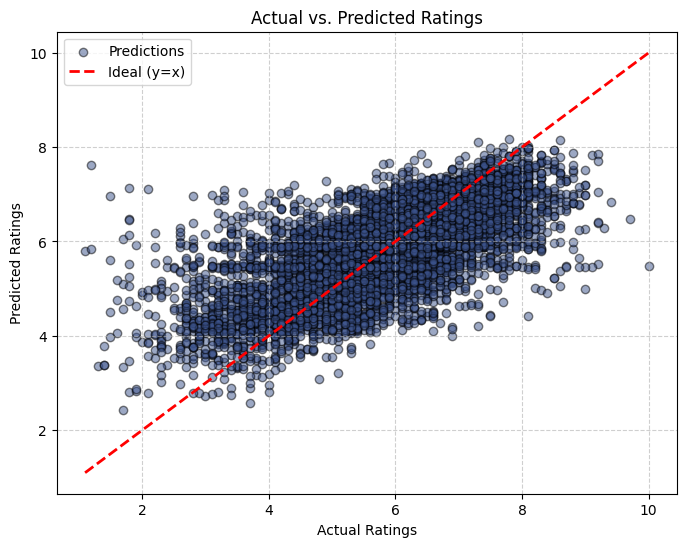

In [22]:
# Test set tahminlerini al
y_pred = best_model.predict(X_test)

plt.figure(figsize=(8, 6))

# Main scatter plot
plt.scatter(y_test, y_pred, alpha=0.5, color='#3b528b', edgecolor='k', label='Predictions')

# Reference Line (Perfect Prediction)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal (y=x)')

plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs. Predicted Ratings")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

This scatter plot shows that the model generally predicts ratings in the right direction. Most points are close to the diagonal line, which means the predicted values are usually similar to the real values.

But the points spread out more, tells us the model is not perfect and sometimes makes bigger mistakes. This is normal because movie ratings depend on many subjective things, like personal taste or story quality, which are hard to capture with data.

### 10.2 Residual Plot

This plot checks for **bias** and **patterns in errors**. 
* We want to see a random cloud of points centered around the red line (0 error).
* If we see a pattern (like a funnel shape or curve), it suggests the model might be missing important information or relationships.
* Our Random Forest model shows a relatively random distribution around zero, indicating that it captures most of the underlying patterns in the data.

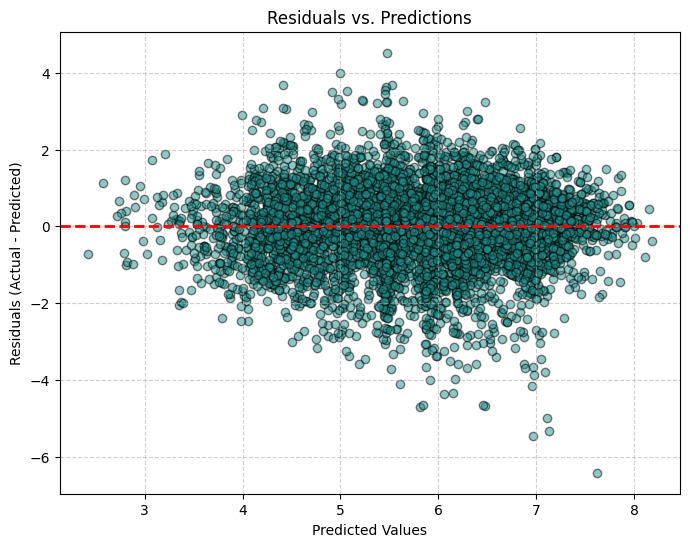

In [23]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='#21918c', edgecolor='k')
plt.axhline(0, color='r', linestyle='--', lw=2)

plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predictions")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In the residual plot, the points are spread around zero without forming any strong systematic pattern. This is a good sign because it means:

* **No major systematic bias** - The model doesn't consistently over-predict or under-predict for specific ranges.
* **Random Forest captures non-linear relationships** - Unlike linear models, Random Forest can model complex patterns, and the relatively random residual distribution confirms this.
* **Acceptable variance** - Though residuals have some spread, it's expected given the subjective nature of movie ratings.

However, the residuals still have a considerable range, meaning some predictions are far from actual values. This is normal because movie ratings depend on many subjective factors (personal taste, cultural context, timing) that are inherently difficult to capture even with sophisticated features and ensemble methods like Random Forest.

### 10.3 Error Distribution

The histogram shows the spread of our errors.

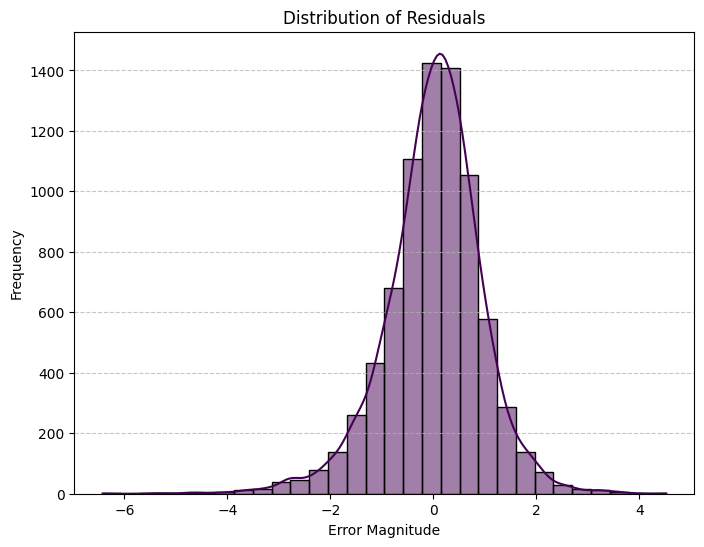

In [24]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='#440154', bins=30)
plt.title("Distribution of Residuals")
plt.xlabel("Error Magnitude")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The error distribution looks like a bell-shaped curve centered around zero. This means:

* The errors are mostly normal and balanced,
* The model doesn’t consistently guess too high or too low,
* Most predictions are close to the real rating.

There are a few errors that are larger than usual, but this is expected in real datasets, especially when dealing with human opinions like movie ratings.

### 10.4 Learning Curve Analysis

The Learning Curve helps us diagnose bias and variance by plotting the model's performance on the training set and the validation set.

* **Training Score (Red):** How well the model learns from the data it has seen.
* **Cross-Validation Score (Green):** How well the model generalizes to new, unseen data.

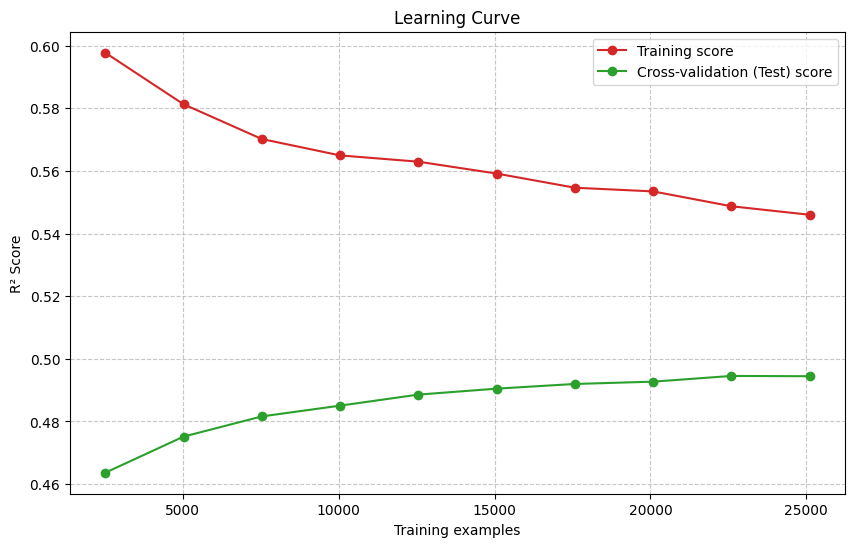

In [26]:
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='r2'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#d62728", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#2ca02c", label="Cross-validation (Test) score")
    
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("R² Score")
    plt.legend(loc="best")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Run the plot
plot_learning_curve(best_model, X_train, y_train)

**Observation:**

The learning curve reveals critical insights about the model's behavior:

1.  **Consistent Gap:** There's a persistent gap of about 0.05-0.10 between training and validation scores throughout. This indicates the model has some variance but is primarily limited by bias - it's not complex enough to capture all patterns in the data.

2.  **Plateau Effect:** After about 15,000-20,000 samples, both curves flatten significantly. Adding more training data beyond this point provides minimal improvement, suggesting we've reached the model's learning capacity with the current feature set.

3.  **What This Means:**
   - **More data won't help much** - The curves have plateaued, indicating data sufficiency.
   - **Better features needed** - To improve performance, we'd need more informative features or a more complex model architecture rather than more examples.
   - **Acceptable performance** - Given the subjective nature of movie ratings, an R² of ~0.49 on unseen data is reasonable.